In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter
from torchvision import models
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
from torchvision import transforms
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torch.utils.data import random_split

In [29]:
data_dir = '/Users/franciszeklasinski/Desktop/Projekty Github/Brain MRI/archive-4/brain_tumor_dataset'


dataset = datasets.ImageFolder(data_dir)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

class_names = dataset.classes
print("Klasy:", class_names)
print("Liczba próbek w zbiorze:", len(dataset))

Klasy: ['no', 'yes']
Liczba próbek w zbiorze: 253


In [30]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Dataset z transformacjami
transformed_dataset = ImageFolder(data_dir, transform=transform)

# Podział 80% trening, 20% walidacja
train_size = int(0.8 * len(transformed_dataset))
val_size = len(transformed_dataset) - train_size
train_dataset, val_dataset = random_split(transformed_dataset, [train_size, val_size])

# Utworzenie loaderów z transformowanymi danymi
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Rozmiar zbioru treningowego: {len(train_dataset)}")
print(f"Rozmiar zbioru walidacyjnego: {len(val_dataset)}")

# Sprawdzenie rozkładu klas w oryginalnym zbiorze
from collections import Counter
all_labels = [dataset[i][1] for i in range(len(dataset))]
class_distribution = Counter(all_labels)
print(f"Rozkład klas: {dict(class_distribution)}")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {class_distribution[i]} próbek")

Rozmiar zbioru treningowego: 202
Rozmiar zbioru walidacyjnego: 51
Rozkład klas: {0: 98, 1: 155}
  no: 98 próbek
  yes: 155 próbek


Przykładowe zdjęcia:


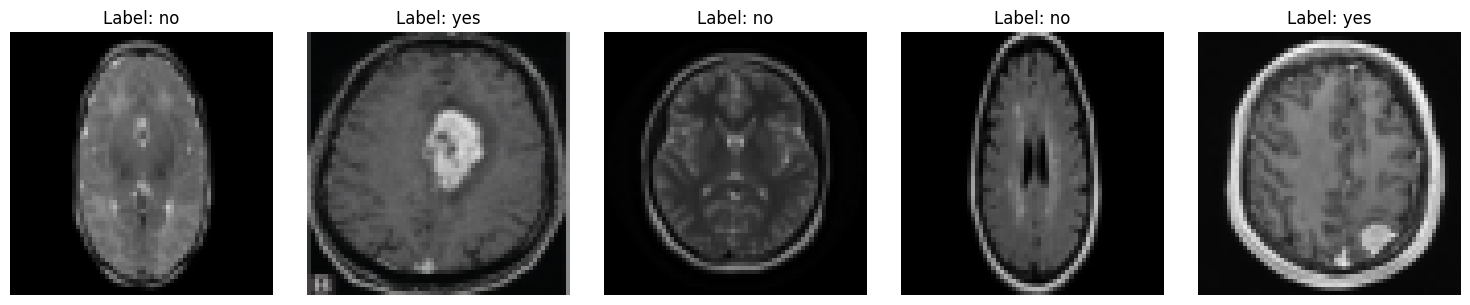

In [31]:
def imshow(img, title=None):
    img = img / 2 + 0.5  # denormalizacja
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()

plain_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

plain_dataset = ImageFolder(data_dir, transform=plain_transform)
plain_loader = DataLoader(plain_dataset, batch_size=16, shuffle=True)

dataiter = iter(plain_loader)
images, labels = next(dataiter)

print("Przykładowe zdjęcia:")
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = images[i] / 2 + 0.5  
    npimg = img.numpy()
    axes[i].imshow(np.transpose(npimg, (1, 2, 0)))
    axes[i].set_title(f"Label: {class_names[labels[i]]}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [32]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.25),

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.25),

            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.3),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [33]:
# Funkcja testująca
def test(model, loader, loss_fn, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_loss = running_loss / total
    avg_acc = correct / total
    return avg_loss, avg_acc

In [34]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
loss_fn = nn.CrossEntropyLoss()

advanced_cnn = Model().to(device)
opt_advanced = torch.optim.Adam(advanced_cnn.parameters(), lr=0.0001)
writer = SummaryWriter("runs/brain-tumor-cnn-classifier")

epochs = 19
train_losses_adv, val_losses_adv = [], []
train_accs_adv, val_accs_adv = [], []

for epoch in range(epochs):
    advanced_cnn.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader: 
        images, labels = images.to(device), labels.to(device)
        opt_advanced.zero_grad()
        outputs = advanced_cnn(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt_advanced.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / total
    train_acc = correct / total

    val_loss, val_acc = test(advanced_cnn, val_loader, loss_fn, device) 
    print(f"Epoka {epoch+1}/{epochs} | Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | Val loss: {val_loss:.4f}, acc: {val_acc:.4f}")

    train_losses_adv.append(train_loss)
    val_losses_adv.append(val_loss)
    train_accs_adv.append(train_acc)
    val_accs_adv.append(val_acc)
writer.close()

Epoka 1/19 | Train loss: 0.7293, acc: 0.5446 | Val loss: 0.6781, acc: 0.5882
Epoka 2/19 | Train loss: 0.6675, acc: 0.6238 | Val loss: 0.6769, acc: 0.7843
Epoka 2/19 | Train loss: 0.6675, acc: 0.6238 | Val loss: 0.6769, acc: 0.7843
Epoka 3/19 | Train loss: 0.6217, acc: 0.6436 | Val loss: 0.6050, acc: 0.7255
Epoka 3/19 | Train loss: 0.6217, acc: 0.6436 | Val loss: 0.6050, acc: 0.7255
Epoka 4/19 | Train loss: 0.5827, acc: 0.6931 | Val loss: 0.5970, acc: 0.6863
Epoka 4/19 | Train loss: 0.5827, acc: 0.6931 | Val loss: 0.5970, acc: 0.6863
Epoka 5/19 | Train loss: 0.5394, acc: 0.7030 | Val loss: 0.5163, acc: 0.7647
Epoka 5/19 | Train loss: 0.5394, acc: 0.7030 | Val loss: 0.5163, acc: 0.7647
Epoka 6/19 | Train loss: 0.5783, acc: 0.7129 | Val loss: 0.5377, acc: 0.7647
Epoka 6/19 | Train loss: 0.5783, acc: 0.7129 | Val loss: 0.5377, acc: 0.7647
Epoka 7/19 | Train loss: 0.5490, acc: 0.7079 | Val loss: 0.5073, acc: 0.8039
Epoka 7/19 | Train loss: 0.5490, acc: 0.7079 | Val loss: 0.5073, acc: 0.8039

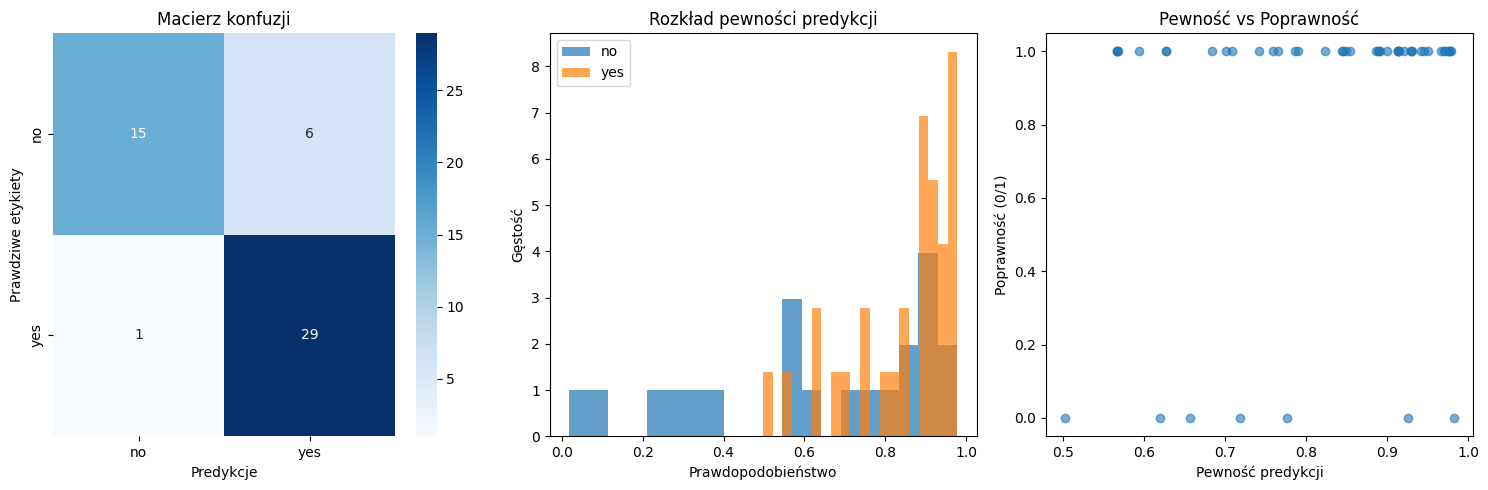


Szczegółowy raport klasyfikacji:
              precision    recall  f1-score   support

          no       0.94      0.71      0.81        21
         yes       0.83      0.97      0.89        30

    accuracy                           0.86        51
   macro avg       0.88      0.84      0.85        51
weighted avg       0.87      0.86      0.86        51



In [37]:
# Funkcja do pobierania predykcji
def get_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)


true_labels, pred_labels, probabilities = get_predictions(advanced_cnn, val_loader, device)

# Macierz konfuzji
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Macierz konfuzji')
plt.ylabel('Prawdziwe etykiety')
plt.xlabel('Predykcje')

# Rozkład prawdopodobieństw
plt.subplot(1, 3, 2)
for i, class_name in enumerate(class_names):
    class_probs = probabilities[true_labels == i, i]
    plt.hist(class_probs, alpha=0.7, bins=20, label=f'{class_name}', density=True)
plt.xlabel('Prawdopodobieństwo')
plt.ylabel('Gęstość')
plt.title('Rozkład pewności predykcji')
plt.legend()

# Przykładowe predykcje z prawdopodobieństwami
plt.subplot(1, 3, 3)
confident_correct = np.where((pred_labels == true_labels) & (np.max(probabilities, axis=1) > 0.9))[0]
uncertain = np.where(np.max(probabilities, axis=1) < 0.7)[0]
mistakes = np.where(pred_labels != true_labels)[0]


# Wykres dokładności vs pewność
certainties = np.max(probabilities, axis=1)
accuracies = (pred_labels == true_labels).astype(int)
plt.scatter(certainties, accuracies, alpha=0.6)
plt.xlabel('Pewność predykcji')
plt.ylabel('Poprawność (0/1)')
plt.title('Pewność vs Poprawność')

plt.tight_layout()
plt.show()

# Raport klasyfikacji
print("\nSzczegółowy raport klasyfikacji:")
print(classification_report(true_labels, pred_labels, target_names=class_names))

Wizualizacja predykcji modelu:


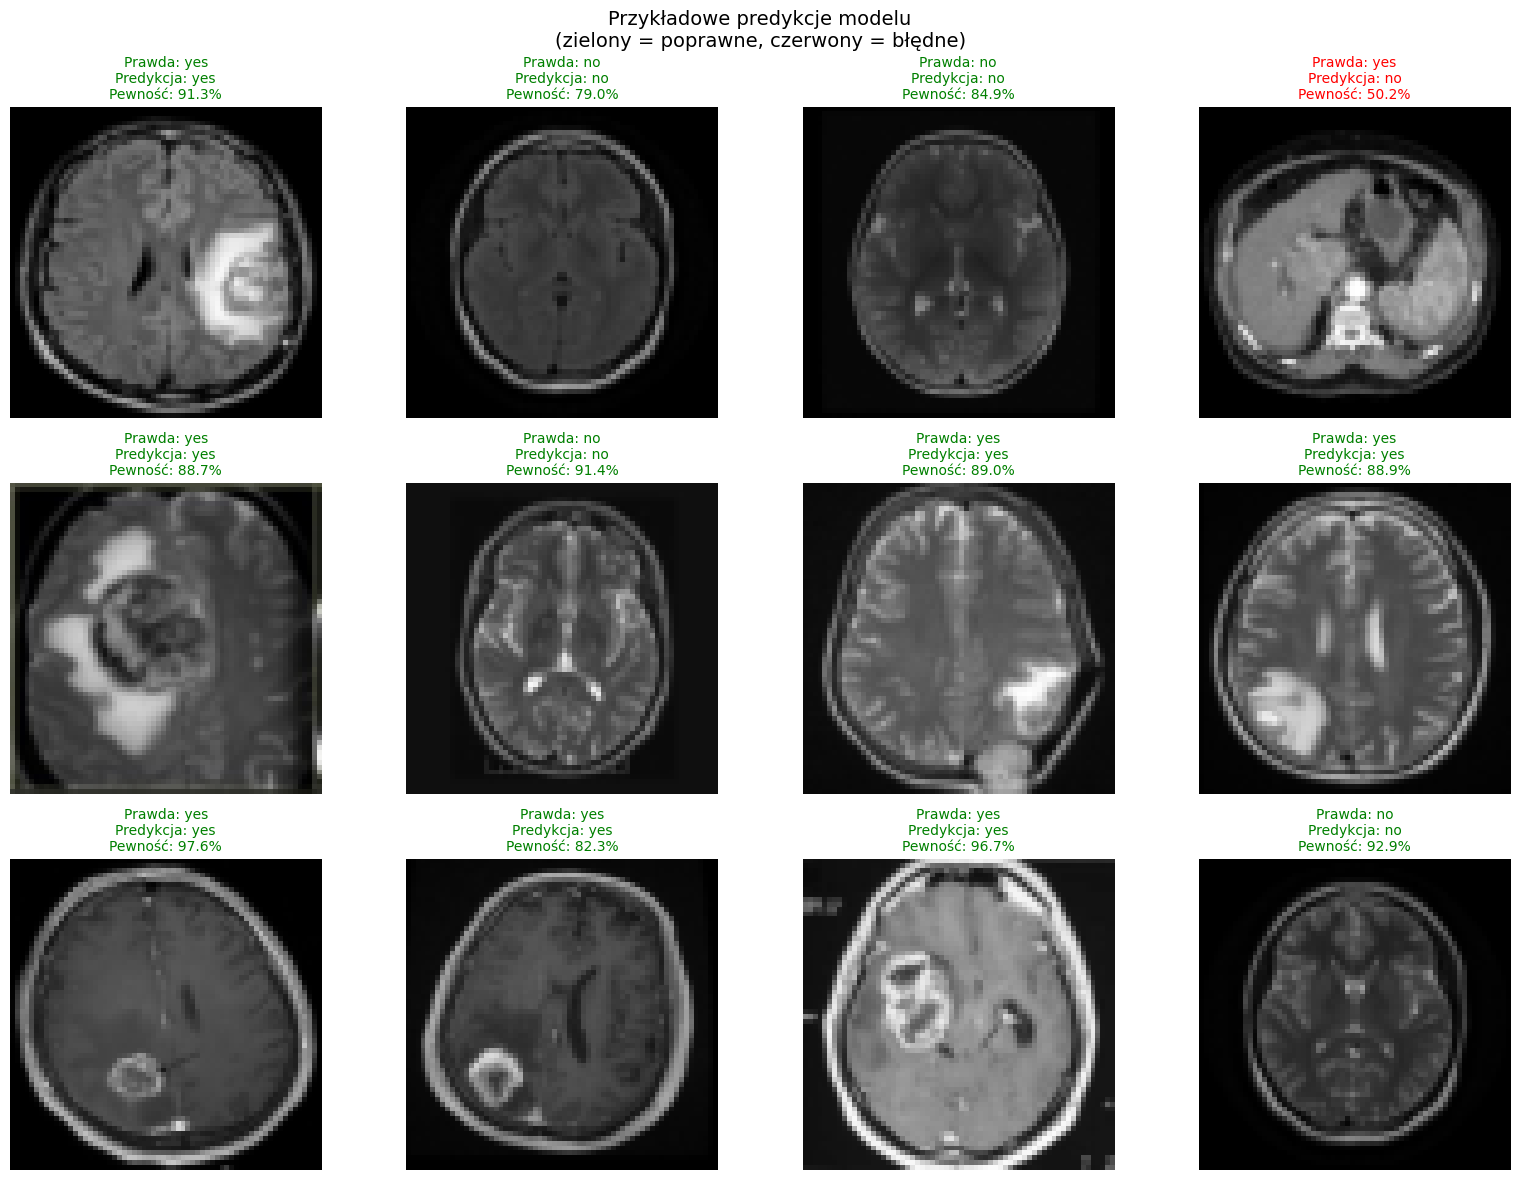

In [ ]:
# Wizualizacja przykładowych predykcji
def visualize_predictions(model, loader, device, num_images=12):
    model.eval()
    images_shown = 0
    
    plt.figure(figsize=(16, 12))
    
    with torch.no_grad():
        for images, labels in loader:
            if images_shown >= num_images:
                break
                
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            images = images.cpu()
            
            for i in range(min(len(images), num_images - images_shown)):
                plt.subplot(3, 4, images_shown + 1)
                
                img = images[i] / 2 + 0.5
                img = torch.clamp(img, 0, 1)
                npimg = img.numpy()
                npimg = np.transpose(npimg, (1, 2, 0))
                
                plt.imshow(npimg)
                true_label = class_names[labels[i]]
                pred_label = class_names[preds[i]]
                confidence = probs[i][preds[i]].item() * 100
                color = 'green' if preds[i] == labels[i] else 'red'
                plt.title(f'Prawda: {true_label}\nPredykcja: {pred_label}\nPewność: {confidence:.1f}%', 
                         fontsize=10, color=color)
                plt.axis('off')
                
                images_shown += 1
                if images_shown >= num_images:
                    break
            
            if images_shown >= num_images:
                break
    
    plt.suptitle('Przykładowe predykcje modelu\n(zielony = poprawne, czerwony = błędne)', 
                 fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()

print("Wizualizacja predykcji modelu:")
visualize_predictions(advanced_cnn, val_loader, device, num_images=12)